# Using `load_stac` in openEO for accessing external datasets (Biomass example)

Accessing and analyzing diverse, ever-growing datasets is a significant challenge in remote sensing. 
These datasets are often scattered across various sources, making them difficult to integrate. 
To address this issue, the openEO team introduced a new feature called 
[`load_stac`](https://open-eo.github.io/openeo-python-client/api-processes.html#openeo.processes.load_stac).

A recent [openEO notebook](https://github.com/Open-EO/openeo-community-examples/tree/main/python/LoadStac) 
demonstrates how to use the `load_stac` feature by creating an STAC item to integrate personal files. 
Using that notebook as a reference, 
here we explain how to retrieve similarly created external collections and combine them with existing datasets in the openEO ecosystem for basic analysis.

#### Establishing a connection to openEO

As the first step in using openEO, we will establish a connection to the openEO backend on the Copernicus Data Space Ecosystem (CDSE) and authenticate the session via OpenID Connect.

In [2]:
import openeo

connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


This step sets up the required connection to the CDSE backend.

In this example, we want to explore the relationship between **belowground biomass** (as an indicator of vegetation or forest cover) and **elevation** (DEM data).  
Combining these two datasets—biomass from 2010 and digital elevation model (DEM) data—we can examine how belowground biomass distribution varies with elevation.
This could help in understanding patterns of forest cover in mountainous regions or how vegetation responds to terrain changes, such as slopes or valleys.

The Harmonized Global Biomass for 2010 is available from the Microsoft Planetary Computer STAC, and the Copernicus DEM is available from the CDSE backend.

Next, identify the spatial and temporal extent of the dataset of interest. 

In [3]:
# Define your area of interest (for example, a specific bounding box)
spatial_extent = {
    "west": -60.0,
    "south": -10.0,
    "east": -59.5,
    "north": -9.5
}

# Define the temporal extent
temporal_extent = ["2010-12-31", "2010-12-31"]

We use the `load_stac` function to load the biomass dataset to retrieve data from an external STAC source. In this case, we specify the desired bands, but if no bands are provided, all available bands will be loaded by default.

Please note that `load_stac` reads data from external providers and writes it to the CDSE backend before processing. For large areas, this can lead to slower execution times and potentially higher costs. Therefore, it is advisable to use this feature cautiously by filtering for specific bands and limiting the spatial extent to avoid processing vast areas.

In [4]:
# Load biomass data for 2010 (only available for December 31)
biomass_2010 = connection.load_stac(
    "https://planetarycomputer.microsoft.com/api/stac/v1/collections/hgb",
    spatial_extent=spatial_extent,
    temporal_extent=temporal_extent,
    bands=["belowground"]
)

Using `load_stac`, we could fetch data from an external provider (Microsoft Planetary Computer in this case) and filter it according to our requirements. Similarly, publicly available data stored in STAC collections or items can be accessed using this openEO feature for further analysis.

For the same spatial extent, we then load the COPERNICUS_30 DEM data from the CDSE backend.

In [5]:
elevation = connection.load_collection(
    "COPERNICUS_30", 
    spatial_extent=spatial_extent, 
    bands=["DEM"]
)

Since there is only one timestep, the data is aggregated by taking the mean over time for both biomass and elevation datasets. This step removes the time dimension, making it easier to combine the two datasets.

In [6]:
# reduce the temporal dimension
elevation = elevation.mean_time() 
biomass_2010 = biomass_2010.mean_time() 

The two datasets (biomass and elevation) are merged using the `merge_cubes` method. This allows for further spatial and temporal analysis of the combined data.

In [7]:
merged = biomass_2010.merge_cubes(elevation)

As a final step in the openEO workflow, we download the data using a synchronous option. The result can thn be visualized using a plotting library.

In [8]:
merged.download("biomass_elevation.tiff")

Text(0, 0.5, 'Biomass Carbon Density')

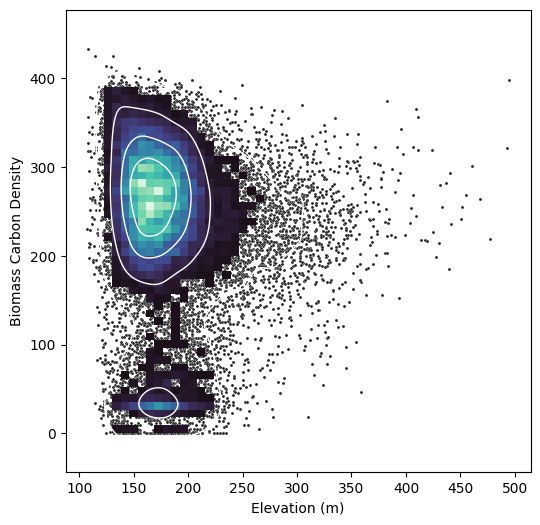

In [9]:
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns

img = rasterio.open("biomass_elevation.tiff").read()
biomass=img[0].flatten()
elevation=img[1].flatten()


f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=elevation, y=biomass, s=5, color=".15")
sns.histplot(x=elevation, y=biomass, bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=elevation, y=biomass, levels=5, color="w", linewidths=1)
ax.set_xlabel("Elevation (m)")
ax.set_ylabel("Biomass Carbon Density")

From this example plot we can see that in our study area the below-ground carbon biomass is mostly located at the elevation of 150-200 meters with value in the range of 200-400 kg/ha. Even though higher elevation also has biomass it is rarely below the range of 100 kg/ha. This shows an example of how we can combine different sources of data in OpenEO to perform a data assimilation and analysis.

This example highlights the flexibility of openEO in accessing and combining external datasets via STAC. This was a simple example, but the same approach can be used for more complex analyses involving multiple datasets from different sources.